In [1]:
import geopandas as gpd
from shapely.geometry import Polygon
# Get barcode coordinates
#first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col = get_barcode_coordinates(df, one_micron)
geojson_file = '../data/processed/dataframe_ground_truth.geojson'

# Read GeoJSON file into a GeoDataFrame
gdf = gpd.read_file(geojson_file)

geometry = gdf[gdf['path_class'] == 'overlap_comparison']['geometry'].iloc[0]

# Access exterior coordinates of the polygon
coordinates = geometry.exterior.coords.xy

# Assign coordinates to variables
first_barcode_pxl_row = int(min((coordinates[1])))  # Y-coordinate of the first point
first_barcode_pxl_col = int(min(coordinates[0]))# X-coordinate of the first point
last_barcode_pxl_row = int(max(coordinates[1]))  # Y-coordinate of the last point
last_barcode_pxl_col = int(max(coordinates[0]))  # X-coordinate of the last point

print(first_barcode_pxl_row, first_barcode_pxl_col,last_barcode_pxl_row,last_barcode_pxl_col)


38327 32146 40614 33320


In [2]:
import sys
sys.path.append('../utils')
import os

# Importing importlib for module reloading
import importlib
import image_cropp_utils

# Reloading the module
importlib.reload(image_cropp_utils)

from image_cropp_utils import read_image, crop_image, save_image_as_btf

# Read the image
dir_base = '../data/raw/p5/'
filename = 'Visium_HD_Human_Colon_Cancer_P5_tissue_image.btf'
img = read_image(dir_base + filename)

# Crop the image using the calculated coordinates
cropped_img = crop_image(img, first_barcode_pxl_row, first_barcode_pxl_col, last_barcode_pxl_row, last_barcode_pxl_col)

print(cropped_img.shape)

output_filename = 'p5_cropped_image_overlap_comparison.btf'
output_dir = '../data/processed'
output_path = os.path.join(output_dir, output_filename)
save_image_as_btf(cropped_img, output_path)

(2287, 1174, 3)
Cropped image saved as ../data/processed/p5_cropped_image_overlap_comparison.btf


In [3]:
import sys
sys.path.append('../utils')

# Importing importlib for module reloading
import importlib
import image_segmentation, geodataframe_creation

# Reloading the module
importlib.reload(image_segmentation)

from skimage.io import imread
from image_segmentation import segment_image
from geodataframe_creation import create_geodataframe
from shapely.geometry import Polygon, box

# Assuming you have loaded 'cropped_img' using imread or some other method
#cropped_img = read your btf from previous step

# Perform image segmentation
polys = segment_image(cropped_img)

# Create GeoDataFrame from segmented polygons
gdf = create_geodataframe(polys)

gdf.to_file('../data/processed/dataframe_stardist_overlap_comparison.geojson', driver='GeoJSON')

# Now 'gdf' contains the GeoDataFrame with polygons and IDs
print(gdf.head())


2024-07-18 12:58:43.607783: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found model '2D_versatile_he' for 'StarDist2D'.
Loading network weights from 'weights_best.h5'.
Loading thresholds from 'thresholds.json'.
Using default values: prob_thresh=0.692478, nms_thresh=0.3.
effective: block_size=(1008, 1008, 3), min_overlap=(128, 128, 0), context=(128, 128, 0)


100%|██████████| 8/8 [00:49<00:00,  6.21s/it]


                                            geometry    id
0  POLYGON ((816.412 152.000, 816.272 154.043, 81...  ID_1
1  POLYGON ((233.235 692.000, 233.090 693.410, 23...  ID_2
2  POLYGON ((770.699 516.000, 770.070 519.594, 76...  ID_3
3  POLYGON ((732.985 174.000, 731.892 176.763, 73...  ID_4
4  POLYGON ((795.360 10.000, 795.581 11.508, 795....  ID_5


In [4]:
import geopandas as gpd
from shapely.geometry import Polygon, box

# Load the GeoDataFrame
gdf = gpd.read_file('../data/processed/dataframe_ground_truth.geojson')
gdf.crs = None

# Create a bounding box Polygon using the coordinates
bounding_box = box(first_barcode_pxl_col, first_barcode_pxl_row, last_barcode_pxl_col, last_barcode_pxl_row)

# Function to adjust polygon coordinates
def adjust_polygon(polygon, x_offset, y_offset):
    new_coords = [(float(x - x_offset), float(y - y_offset)) for x, y in polygon.exterior.coords]
    return Polygon(new_coords)

# Filter the GeoDataFrame where path_class is null
gdf_filtered = gdf[gdf['path_class'].isnull()].copy()

# Remove polygons outside the bounding box
gdf_filtered = gdf_filtered[gdf_filtered['geometry'].apply(lambda poly: poly.intersects(bounding_box))]

# Adjusting the coordinates in the filtered GeoDataFrame using .loc to avoid SettingWithCopyWarning
gdf_filtered.loc[:, 'geometry'] = gdf_filtered['geometry'].apply(lambda poly: adjust_polygon(poly, first_barcode_pxl_col, first_barcode_pxl_row))

# Save the updated GeoDataFrame back to a new GeoJSON file
gdf_filtered.to_file('../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson', driver='GeoJSON')

# Display the updated geometries
print(gdf_filtered['geometry'])


0       POLYGON ((784.000 -4.000, 782.000 -3.000, 781....
1       POLYGON ((712.000 -5.000, 710.000 -4.000, 709....
2       POLYGON ((10.000 2230.000, 9.000 2231.000, 8.0...
3       POLYGON ((24.000 2263.000, 23.000 2264.000, 21...
4       POLYGON ((-15.000 2253.000, -16.000 2254.000, ...
                              ...                        
1363    POLYGON ((1058.000 2058.000, 1056.000 2059.000...
1364    POLYGON ((1111.000 2028.000, 1109.000 2029.000...
1365    POLYGON ((1094.000 1951.000, 1091.000 1952.000...
1366    POLYGON ((1081.000 1985.000, 1078.000 1986.000...
1485    POLYGON ((1177.000 96.000, 1176.000 97.000, 11...
Name: geometry, Length: 935, dtype: geometry


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


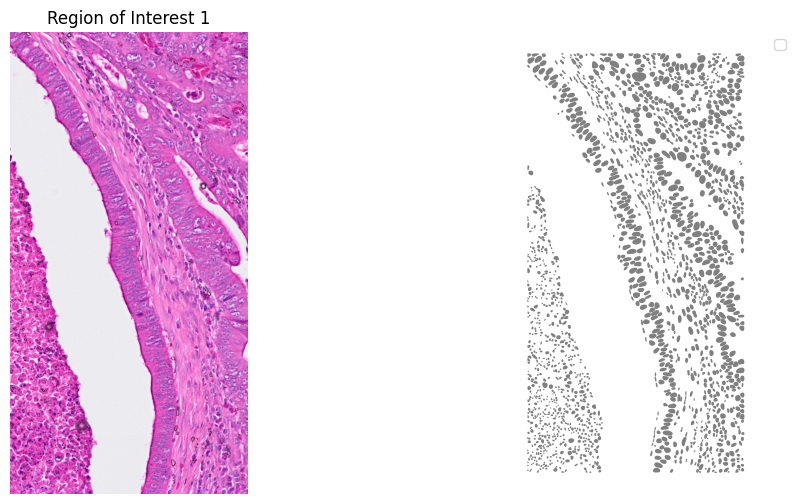

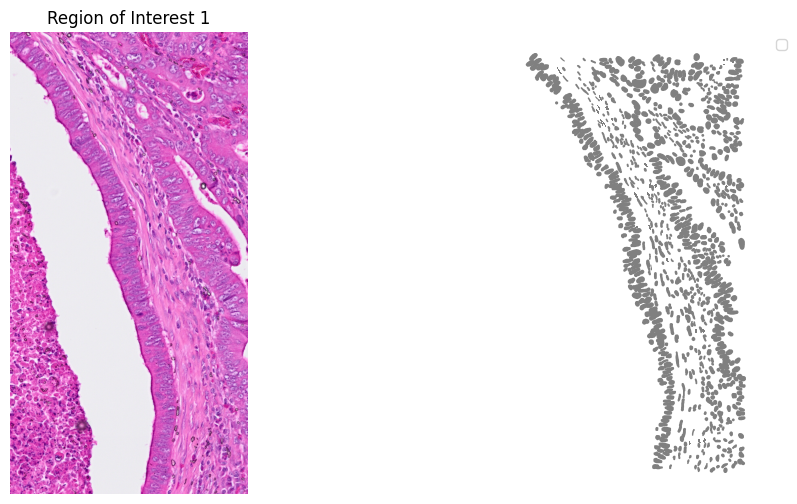

In [5]:
import importlib
import image_plot_utils

# Reloading the module
importlib.reload(image_plot_utils)

from skimage.io import imread
from image_plot_utils import plot_mask_and_save_image
from matplotlib.colors import ListedColormap

cmap=ListedColormap(['grey'])
gdf = gpd.read_file('../data/processed/dataframe_stardist_overlap_comparison.geojson')
gdf.crs = None
plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_stardist.ROI1.tif")


file_path = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'
gdf3 = gpd.read_file(file_path)
gdf3.crs = gdf.crs

plot_mask_and_save_image(title="Region of Interest 1",
                         gdf=gdf_filtered,
                         cmap=cmap,
                         img=cropped_img,
                         output_name="../data/processed/p5_image_mask_Chang.ROI1.tif")


interactiveshell.py (3466): The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.


           id                                           geometry  index_right  \
2        ID_3  POLYGON ((770.699 516.000, 770.070 519.594, 76...           99   
42      ID_43  POLYGON ((800.542 504.000, 800.661 507.314, 80...           99   
2        ID_3  POLYGON ((770.699 516.000, 770.070 519.594, 76...           98   
83      ID_84  POLYGON ((787.696 536.000, 784.852 539.352, 78...           98   
3        ID_4  POLYGON ((732.985 174.000, 731.892 176.763, 73...          118   
...       ...                                                ...          ...   
1855  ID_1856  POLYGON ((990.481 2146.000, 991.080 2147.408, ...          912   
1861  ID_1862  POLYGON ((988.074 2164.000, 987.797 2164.755, ...          912   
1857  ID_1858  POLYGON ((1168.577 1958.000, 1168.261 1959.245...           62   
1864  ID_1865  POLYGON ((1173.884 1884.000, 1173.295 1885.849...           52   
1879  ID_1880  POLYGON ((942.092 2282.000, 943.092 2283.411, ...           51   

      path_class  
2       

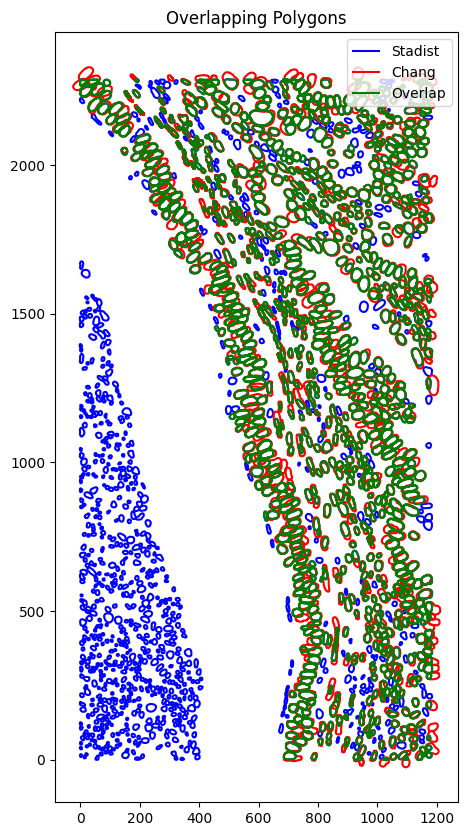

In [6]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths to the GeoJSON files
file_path1 = '../data/processed/dataframe_stardist_overlap_comparison.geojson'
file_path2 = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf1 = gpd.read_file(file_path1)
gdf2 = gpd.read_file(file_path2)

# Ensure both GeoDataFrames have the same CRS
gdf2.crs = None
gdf1.crs = None

# Perform a spatial join to find overlapping polygons
# 'inner' join will keep only overlapping polygons
overlap_gdf = gpd.sjoin(gdf1, gdf2, how='inner', op='intersects')

# Print the resulting overlapping polygons
print(overlap_gdf)

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Chang')
overlap_gdf.boundary.plot(ax=ax, color='green', label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()


Red nuclei count: 935
Blue nuclei count: 1881
Green nuclei count: 1507


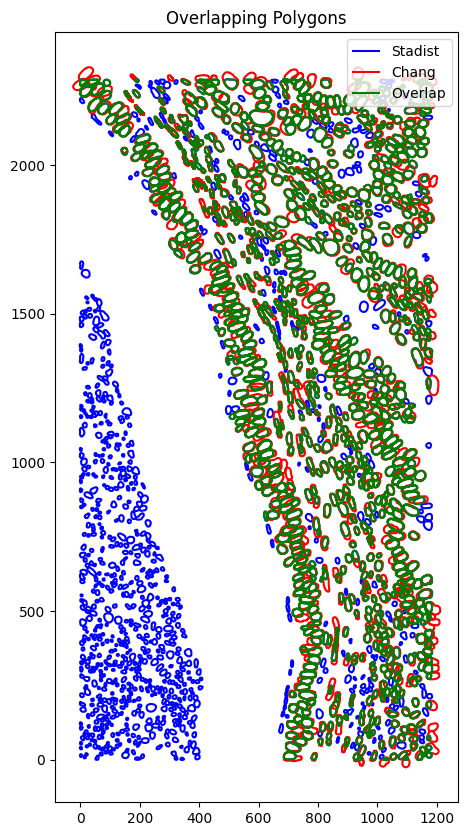

In [7]:
# Count the red nuclei (polygons in gdf2)
red_nuclei_count = len(gdf2)
blue_nuclei_count = len(gdf1)

# Count the green nuclei (overlapping polygons)
green_nuclei_count = len(overlap_gdf)

# Print the counts
print(f"Red nuclei count: {red_nuclei_count}")
print(f"Blue nuclei count: {blue_nuclei_count}")
print(f"Green nuclei count: {green_nuclei_count}")

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 10))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Chang')
overlap_gdf.boundary.plot(ax=ax, color='green', label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()

interactiveshell.py (3466): The `op` parameter is deprecated and will be removed in a future release. Please use the `predicate` parameter instead.
2438649625.py (21): Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



Red nuclei count: 935
Green nuclei count: 856


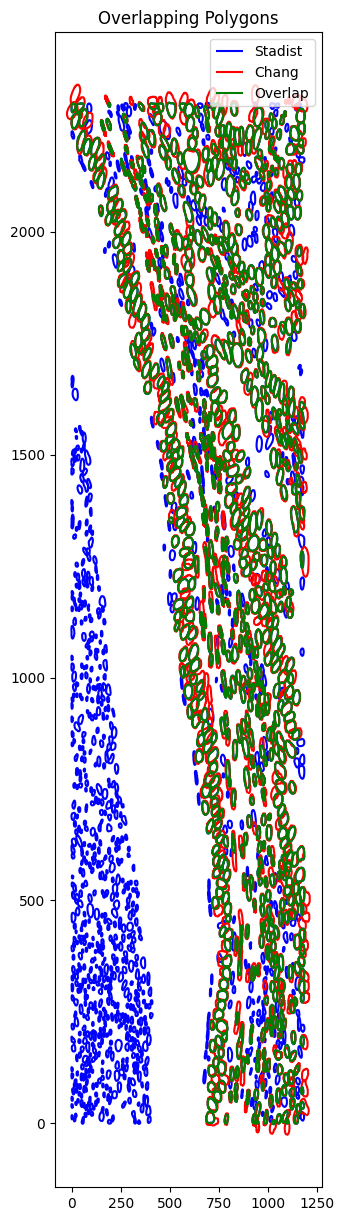

In [8]:
import geopandas as gpd
import matplotlib.pyplot as plt

# File paths to the GeoJSON files
file_path1 = '../data/processed/dataframe_stardist_overlap_comparison.geojson'
file_path2 = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf1 = gpd.read_file(file_path1)
gdf2 = gpd.read_file(file_path2)

# Ensure both GeoDataFrames have the same CRS
gdf1.crs = gdf2.crs

# Perform a spatial join to find overlapping polygons
overlap_gdf = gpd.sjoin(gdf1, gdf2, how='inner', op='intersects')

# Calculate the intersection area and the original area
overlap_gdf['intersection_area'] = overlap_gdf.apply(
    lambda row: row['geometry'].intersection(gdf2.loc[row['index_right'], 'geometry']).area, axis=1)
overlap_gdf['original_area'] = overlap_gdf['geometry'].area

# Filter for more than 50% overlap
overlap_gdf = overlap_gdf[overlap_gdf['intersection_area'] / overlap_gdf['original_area'] > 0.5]

# Count the red nuclei (polygons in gdf2)
red_nuclei_count = len(gdf2)

# Count the green nuclei (overlapping polygons)
green_nuclei_count = len(overlap_gdf)

# Print the counts
print(f"Red nuclei count: {red_nuclei_count}")
print(f"Green nuclei count: {green_nuclei_count}")

# Optionally, plot the overlapping polygons
fig, ax = plt.subplots(figsize=(10, 15))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Chang')
overlap_gdf.boundary.plot(ax=ax, color='green', label='Overlap')
ax.set_title('Overlapping Polygons')
ax.legend()
plt.show()


                                               geometry  jaccard_index  \
0     POLYGON ((816.41205 152.00000, 816.27209 154.0...       0.000000   
1     POLYGON ((233.23497 692.00000, 233.09033 693.4...       0.000000   
2     POLYGON ((770.69891 516.00000, 770.07019 519.5...       0.483037   
3     POLYGON ((732.98505 174.00000, 731.89185 176.7...       0.887737   
4     POLYGON ((795.35968 10.00000, 795.58051 11.507...       0.685726   
...                                                 ...            ...   
1876  POLYGON ((960.03235 1794.00000, 959.44061 1796...       0.000000   
1877  POLYGON ((1144.51025 1766.00000, 1142.91724 17...       0.000000   
1878  POLYGON ((1041.28931 2186.00000, 1041.58453 21...       0.000000   
1879  POLYGON ((942.09229 2282.00000, 943.09174 2283...       0.037934   
1880  POLYGON ((978.91785 1922.00000, 977.94806 1925...       0.026275   

      dice_coefficient  
0             0.000000  
1             0.000000  
2             0.651416  
3          

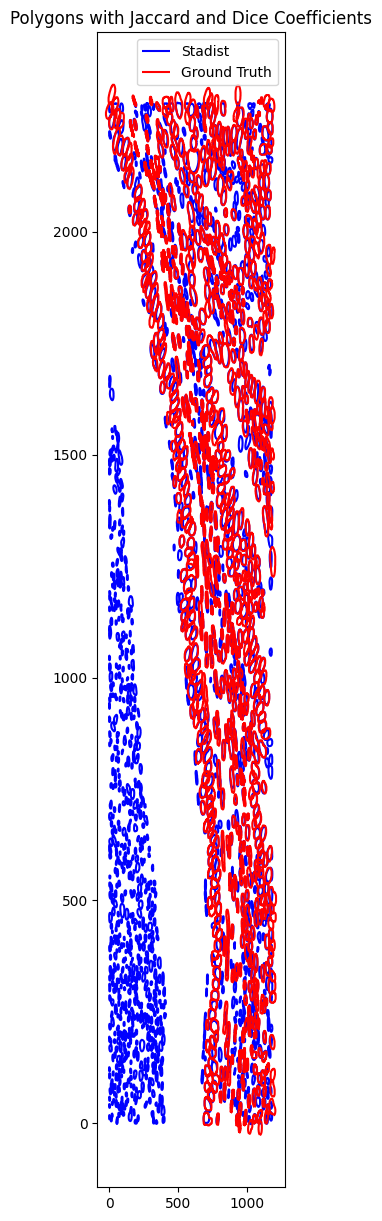

In [9]:
import geopandas as gpd
import matplotlib.pyplot as plt
from shapely.geometry import Polygon

# File paths to the GeoJSON files
file_path1 = '../data/processed/dataframe_stardist_overlap_comparison.geojson'
file_path2 = '../data/processed/updated_dataframe_ground_truth_overlap_comparison_intersect.geojson'

# Read the GeoJSON files into GeoDataFrames
gdf1 = gpd.read_file(file_path1)
gdf2 = gpd.read_file(file_path2)

# Ensure both GeoDataFrames have the same CRS
gdf1.crs = gdf2.crs

# Initialize lists to store Jaccard and Dice coefficients
jaccard_indices = []
dice_coefficients = []

# Function to calculate Dice coefficient
def dice_coefficient(poly1, poly2):
    intersection_area = poly1.intersection(poly2).area
    dice_coeff = 2 * intersection_area / (poly1.area + poly2.area)
    return dice_coeff

# Iterate over each polygon in gdf1
for idx1, row1 in gdf1.iterrows():
    poly1 = row1['geometry']  # Polygon from gdf1

    # Initialize variables to store max coefficients and corresponding polygon in gdf2
    max_jaccard_index = 0
    max_jaccard_polygon = None
    max_dice_coeff = 0
    max_dice_polygon = None

    # Iterate over each polygon in gdf2 to find the maximum coefficients
    for idx2, row2 in gdf2.iterrows():
        poly2 = row2['geometry']  # Polygon from gdf2

        # Calculate Jaccard index
        intersection_area = poly1.intersection(poly2).area
        union_area = poly1.union(poly2).area
        if union_area > 0:
            jaccard_index = intersection_area / union_area
        else:
            jaccard_index = 0

        # Calculate Dice coefficient
        dice_coeff = dice_coefficient(poly1, poly2)

        # Update max Jaccard index and corresponding polygon in gdf2 if current is higher
        if jaccard_index > max_jaccard_index:
            max_jaccard_index = jaccard_index
            max_jaccard_polygon = poly2
        if dice_coeff > max_dice_coeff:
            max_dice_coeff = dice_coeff
            max_dice_polygon = poly2

    # Store the maximum coefficients found for the current polygon in gdf1
    jaccard_indices.append(max_jaccard_index)
    dice_coefficients.append(max_dice_coeff)

# Add Jaccard and Dice coefficients to gdf1 as new columns
gdf1['jaccard_index'] = jaccard_indices
gdf1['dice_coefficient'] = dice_coefficients

# Print the polygons in gdf1 with their corresponding coefficients
print(gdf1[['geometry', 'jaccard_index', 'dice_coefficient']])

# Save gdf1 with coefficients to a GeoJSON file
output_file = '../data/processed/overlap_coefficients.geojson'
gdf1.to_file(output_file, driver='GeoJSON')

# Optionally, plot the polygons in gdf1 and gdf2 with coefficients
fig, ax = plt.subplots(figsize=(10, 15))
gdf1.boundary.plot(ax=ax, color='blue', label='Stadist')
gdf2.boundary.plot(ax=ax, color='red', label='Ground Truth')
ax.set_title('Polygons with Jaccard and Dice Coefficients')
ax.legend()
plt.show()


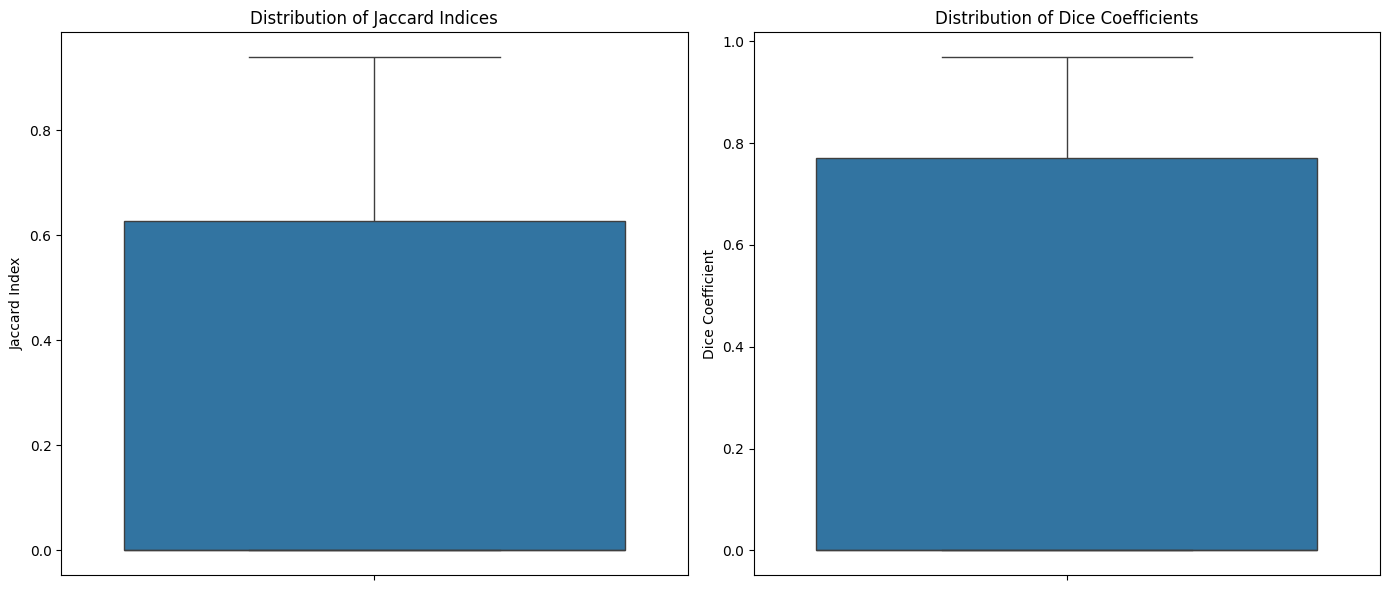

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns

# Create a figure with two subplots side by side
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))

# Boxplot for Jaccard indices
sns.boxplot(data=gdf1['jaccard_index'], orient='v', ax=ax1)
ax1.set_title('Distribution of Jaccard Indices')
ax1.set_ylabel('Jaccard Index')

# Boxplot for Dice coefficients
sns.boxplot(data=gdf1['dice_coefficient'], orient='v', ax=ax2)
ax2.set_title('Distribution of Dice Coefficients')
ax2.set_ylabel('Dice Coefficient')

# Adjust layout and display the plot
plt.tight_layout()
plt.show()


3876407997.py (7): Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.



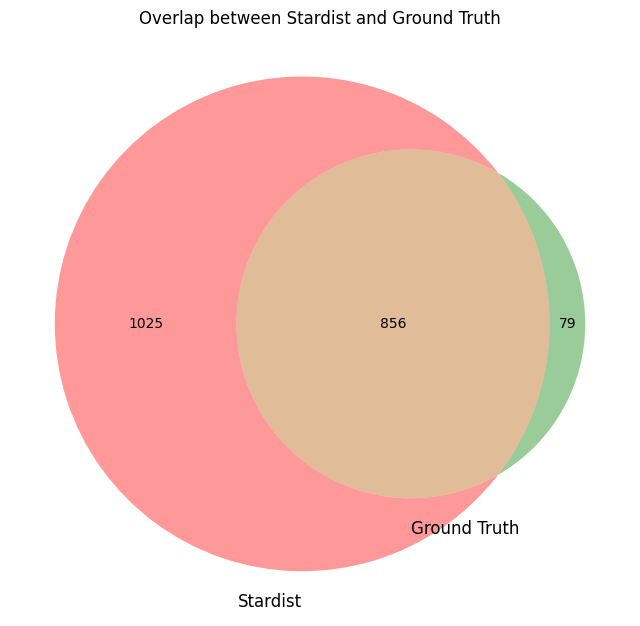

In [11]:
from matplotlib_venn import venn2
import matplotlib.pyplot as plt

# Calculate the intersection area and the original area
overlap_gdf['intersection_area'] = overlap_gdf.apply(
    lambda row: row['geometry'].intersection(gdf2.loc[row['index_right'], 'geometry']).area, axis=1)
overlap_gdf['original_area'] = overlap_gdf['geometry'].area

# Filter for more than 50% overlap
overlap_gdf_05 = overlap_gdf[overlap_gdf['intersection_area'] / overlap_gdf['original_area'] > 0.5]

# Calculate number of unique overlaps
gdf1_non_overlap = len(gdf1) - len(overlap_gdf_05)
gdf2_non_overlap = len(gdf2) - len(overlap_gdf_05)
overlap_count = len(overlap_gdf_05)

# Plot Venn diagram
plt.figure(figsize=(8, 8))
venn2(subsets=(gdf1_non_overlap, gdf2_non_overlap, overlap_count),
      set_labels=('Stardist', 'Ground Truth'))
plt.title('Overlap between Stardist and Ground Truth')
plt.show()
